In [1]:
import os
os.chdir('~/git/Projects/Ntropy_task3/')


# NTROPY : Task 3

Worldline has open sourced some of their data of credit card transactions to
try to predict fraud: https://www.kaggle.com/mlg-ulb/creditcardfraud

Imagine this dataset is cut in half horizontally. Alice has half of the data
and Bob has the other half. Neither of them wants to send their raw data to us.
However, we convince them to let our model learn from their data in a federated
setting. Implement a way for our model to train on the combined data of both
Alice and Bob without either of them sending us any raw data. Does your
approach have a quantifiable "privacy budget" (some approaches do, others don't)?
Compare the accuracy of this model with one which has access to all of the raw
data at once.


In [2]:
from matplotlib import pyplot as plt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jngh48af because the default path (/home/maxime/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from ntropy import *


## I. Load data

In [4]:
data = pd.read_csv(PATH + 'creditcard.csv')

data.head(20)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
def show_graphs(df):
    class_counts = df['Class'].value_counts()
    ax = class_counts.plot(kind='bar')
    for idx, value in class_counts.iteritems():
        ax.annotate(value,
                    (idx, value),
                    xytext=(0, 5),
                    horizontalalignment='center',
                    textcoords='offset points')
    plt.title('Fraud occurrences')
    plt.xlabel('Fraud')
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(data['Amount'])
    plt.title('Histogram of \'Amount\'')
    plt.show()

    plt.hist(np.log10(.1 + data['Amount']))
    plt.title('Histogram of log(1+\'Amount\')')
    plt.show()


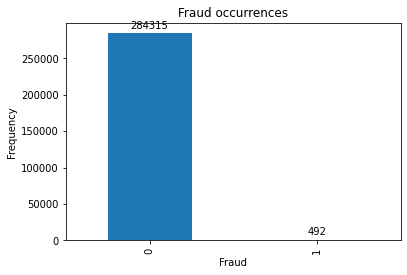

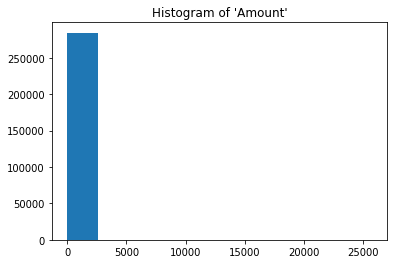

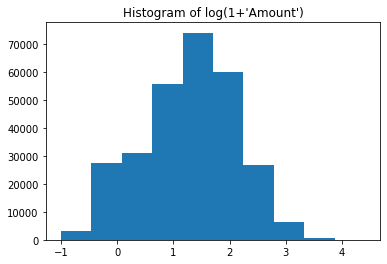

In [6]:
show_graphs(data)


## II. Split Alice & Bob datasets

In [7]:
data_train, data_test = train_test_split_custom(data)


In [8]:
# Only clean data in the train set (to train the autoencoder)
data_train['Class'].value_counts()


0    279395
Name: Class, dtype: int64

In [9]:
# 1/10 of the test set is fraud data
data_test['Class'].value_counts()


0    4920
1     492
Name: Class, dtype: int64

In [10]:
data_alice, data_bob = zip(np.array_split(data_train, 2),
                           np.array_split(data_test, 2))


In [11]:
print(f'Alice train set : {data_alice[0].shape}')
print(f'Alice test set : {data_alice[1].shape}')

print(f'\nBob train set : {data_bob[0].shape}')
print(f'Bob test set : {data_bob[1].shape}')


Alice train set : (139698, 31)
Alice test set : (2706, 31)

Bob train set : (139697, 31)
Bob test set : (2706, 31)


## III. Train autoencoder

In [12]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(input_dim, activation='tanh'),
            layers.Dense(20, activation='tanh'),
            layers.Dense(15, activation='tanh'),
            layers.Dense(latent_dim, activation='elu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(20, activation='tanh'),
            layers.Dense(input_dim, activation='tanh')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## IV. Train the classifier on the encrypted data

In [13]:
# Use an autoencoder to transform the raw data before fitting the model
classifier, (x_test, y_test) = train_on_encrypted_data(data_alice, data_bob)


Epoch 1/250
492/492 [==============================] - 1s 2ms/step - loss: 0.7768 - val_loss: 0.6346
Epoch 2/250
492/492 [==============================] - 1s 1ms/step - loss: 0.6702 - val_loss: 0.5972
Epoch 3/250
492/492 [==============================] - 1s 1ms/step - loss: 0.6390 - val_loss: 0.5696
Epoch 4/250
492/492 [==============================] - 1s 1ms/step - loss: 0.6161 - val_loss: 0.5531
Epoch 5/250
492/492 [==============================] - 1s 1ms/step - loss: 0.6018 - val_loss: 0.5411
Epoch 6/250
492/492 [==============================] - 1s 1ms/step - loss: 0.5910 - val_loss: 0.5312
Epoch 7/250
492/492 [==============================] - 1s 1ms/step - loss: 0.5818 - val_loss: 0.5237
Epoch 8/250
492/492 [==============================] - 1s 1ms/step - loss: 0.5747 - val_loss: 0.5178
Epoch 9/250
492/492 [==============================] - 1s 1ms/step - loss: 0.5690 - val_loss: 0.5121
Epoch 10/250
492/492 [==============================] - 1s 1ms/step - loss: 0.5641 - val_lo

492/492 [==============================] - 1s 1ms/step - loss: 0.4988 - val_loss: 0.4442
Epoch 82/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4985 - val_loss: 0.4441
Epoch 83/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4438
Epoch 84/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4982 - val_loss: 0.4442
Epoch 85/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4979 - val_loss: 0.4431
Epoch 86/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4976 - val_loss: 0.4437
Epoch 87/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4977 - val_loss: 0.4439
Epoch 88/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4973 - val_loss: 0.4427
Epoch 89/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4971 - val_loss: 0.4428
Epoch 90/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4971 - val_loss: 

Epoch 161/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4893 - val_loss: 0.4372
Epoch 162/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4894 - val_loss: 0.4357
Epoch 163/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4892 - val_loss: 0.4350
Epoch 164/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4892 - val_loss: 0.4349
Epoch 165/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4891 - val_loss: 0.4354
Epoch 166/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4890 - val_loss: 0.4347
Epoch 167/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4890 - val_loss: 0.4356
Epoch 168/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4891 - val_loss: 0.4353
Epoch 169/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4889 - val_loss: 0.4346
Epoch 170/250
492/492 [==============================] - 1s 1ms/step - lo

492/492 [==============================] - 1s 1ms/step - loss: 0.4794 - val_loss: 0.4252
Epoch 241/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4796 - val_loss: 0.4249
Epoch 242/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4795 - val_loss: 0.4261
Epoch 243/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4795 - val_loss: 0.4249
Epoch 244/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4795 - val_loss: 0.4252
Epoch 245/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4793 - val_loss: 0.4248
Epoch 246/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4796 - val_loss: 0.4248
Epoch 247/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4792 - val_loss: 0.4256
Epoch 248/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4792 - val_loss: 0.4244
Epoch 249/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4791 - v

492/492 [==============================] - 1s 1ms/step - loss: 0.4815 - val_loss: 0.4731
Epoch 71/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4813 - val_loss: 0.4733
Epoch 72/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4812 - val_loss: 0.4746
Epoch 73/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4810 - val_loss: 0.4732
Epoch 74/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4808 - val_loss: 0.4736
Epoch 75/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4807 - val_loss: 0.4726
Epoch 76/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4805 - val_loss: 0.4726
Epoch 77/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4804 - val_loss: 0.4720
Epoch 78/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4801 - val_loss: 0.4725
Epoch 79/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4800 - val_loss: 

Epoch 150/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4700 - val_loss: 0.4625
Epoch 151/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4698 - val_loss: 0.4628
Epoch 152/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4698 - val_loss: 0.4623
Epoch 153/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4695 - val_loss: 0.4620
Epoch 154/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4694 - val_loss: 0.4616
Epoch 155/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4694 - val_loss: 0.4610
Epoch 156/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4693 - val_loss: 0.4618
Epoch 157/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4693 - val_loss: 0.4615
Epoch 158/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4691 - val_loss: 0.4610
Epoch 159/250
492/492 [==============================] - 1s 1ms/step - lo

492/492 [==============================] - 1s 1ms/step - loss: 0.4649 - val_loss: 0.4571
Epoch 230/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4648 - val_loss: 0.4576
Epoch 231/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4649 - val_loss: 0.4569
Epoch 232/250
492/492 [==============================] - 1s 2ms/step - loss: 0.4649 - val_loss: 0.4572
Epoch 233/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4648 - val_loss: 0.4573
Epoch 234/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4647 - val_loss: 0.4583
Epoch 235/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4647 - val_loss: 0.4580
Epoch 236/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4646 - val_loss: 0.4565
Epoch 237/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4645 - val_loss: 0.4565
Epoch 238/250
492/492 [==============================] - 1s 1ms/step - loss: 0.4644 - v

Results with independently encoded data !

In [14]:
verif_valid(classifier, x_test, y_test)


Confusion matrix :
[[1246    1]
 [  21   85]]
Associated quality metrics :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1247
           1       0.99      0.80      0.89       106

    accuracy                           0.98      1353
   macro avg       0.99      0.90      0.94      1353
weighted avg       0.98      0.98      0.98      1353

AUC score :
0.9005424339168722


## V. Train the classifier on raw data

In [15]:
# Use an autoencoder to transform the raw data before fitting the model
classifier, (x_test, y_test) = train_on_raw_data(data_alice, data_bob)


Results with raw data

In [16]:
verif_valid(classifier, x_test, y_test)


Confusion matrix :
[[1245    2]
 [  14   92]]
Associated quality metrics :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1247
           1       0.98      0.87      0.92       106

    accuracy                           0.99      1353
   macro avg       0.98      0.93      0.96      1353
weighted avg       0.99      0.99      0.99      1353

AUC score :
0.9331603395318576
